In [ ]:
# %env CUDA_VISIBLE_DEVICES=1

In [2]:
import sys
sys.path.append("/notebooks") 
sys.path.append("..")

import numpy as np
# import cupy as cp

from seismiqb.src.utility_classes import Accumulator
from seismiqb.src.functional import to_device, from_device
from batchflow.notifier import Notifier
from seismiqb import metrics

cp = np

In [3]:
def compute_local_new(function, data, bad_traces, kernel_size=3,
                      normalize=True, agg='mean', amortize=False, axis=0, device='cpu', pbar=None):
        i_range, x_range = data.shape[:2]
        k = kernel_size // 2 + 1

        # Transfer to GPU, if needed
        data = to_device(data, device)
        bad_traces = to_device(bad_traces, device)
        xp = cp.get_array_module(data) if (cp is not np) else np

        # Compute data statistics
        data_stds = data.std(axis=-1)
        bad_traces[data_stds == 0.0] = 1
        if normalize:
            data_n = data - data.mean(axis=-1, keepdims=True)
        else:
            data_n = data

        # Pad everything
        padded_data = xp.pad(data_n, ((0, k), (k, k), (0, 0)), constant_values=xp.nan)
        padded_stds = xp.pad(data_stds, ((0, k), (k, k)), constant_values=0.0)
        padded_bad_traces = xp.pad(bad_traces, ((k, k), (k, k)), constant_values=1)

        # Compute metric by shifting arrays
        total = kernel_size * kernel_size - 1
        pbar = Notifier(pbar, total=total//2) if pbar else None

        accumulator = Accumulator(agg=agg, amortize=amortize, axis=axis, total=total)
        for i in range(k):
            for j in range(-k+1, k):
                if (i == 0) and (j <= 0):
                    continue
                shifted_data = padded_data[i:i+i_range, k+j:k+j+x_range]
                shifted_stds = padded_stds[i:i+i_range, k+j:k+j+x_range]
                shifted_bad_traces = padded_bad_traces[k+i:k+i+i_range, k+j:k+j+x_range].copy()
                paired_bad_traces = padded_bad_traces[k-i:k-i+i_range, k-j:k-j+x_range].copy()

                computed = function(data, shifted_data, data_stds, shifted_stds)
                # using symmetry property:
                splitted_computed = computed[:i_range-i, max(0, -j):min(x_range, x_range-j)]
                shifted_computed = xp.pad(splitted_computed,
                                          ((i, 0), (max(0, j), -min(0, j))),
                                          constant_values=xp.nan)

                computed[shifted_bad_traces == 1] = xp.nan
                shifted_computed[paired_bad_traces == 1] = xp.nan   
                accumulator.update(computed)
                accumulator.update(shifted_computed)
                if pbar:
                    pbar.update()

        if pbar:
            pbar.close()

        result = accumulator.get(final=True)
        return from_device(result)

In [4]:
xp = np

X = 1000
Y = 1000
Z = 20

data = np.random.rand(X,Y,Z).astype('float32')

# without data_stds and shifted stds

In [5]:
def vectors_comparison(vector1, vector2, data_stds, shifted_stds):
    res = xp.multiply(vector1, vector2)
    res = xp.sum(xp.power(res, 2), axis = 2)
    return res

In [6]:
data = np.random.randint(0, 2, (X,Y,Z)).astype('float32')
bad_traces=np.ones(data.shape[:2])
bad_traces = np.random.binomial(1, 0.01, size=bad_traces.shape)
data_n = data

In [7]:
res_old = metrics.BaseMetrics.compute_local(_, function=vectors_comparison, data=data_n.copy(), bad_traces=bad_traces.copy(), kernel_size=3,
                      normalize=False, agg='nanmean', amortize=False, axis=0, device='cpu', pbar=True)

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.56it/s]


In [8]:
res_new = compute_local_new(function=vectors_comparison, data=data_n.copy(), bad_traces=bad_traces.copy(), kernel_size=3,
                      normalize=False, agg='nanmean', amortize=False, axis=0, device='cpu', pbar=True)

100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.76it/s]


In [9]:
np.allclose(res_new, res_old, equal_nan=True)

True

In [10]:
np.nanmean(np.abs(res_new - res_old))

0.0

# with data_stds and shifted stds

In [11]:
def vectors_comparison(vector1, vector2, data_stds, shifted_stds):
    res = xp.multiply(vector1, vector2)
    res = xp.sum(xp.power(res, 2), axis = 2)
    res = xp.multiply(res, data_stds)
    res = xp.multiply(res, shifted_stds)
    return res

In [12]:
res_old = metrics.BaseMetrics.compute_local(_, function=vectors_comparison, data=data_n.copy(), bad_traces=bad_traces.copy(), kernel_size=3,
                      normalize=False, agg='nanmean', amortize=False, axis=0, device='cpu', pbar=True)

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  2.93it/s]


In [13]:
res_new = compute_local_new(function=vectors_comparison, data=data_n.copy(), bad_traces=bad_traces.copy(), kernel_size=3,
                      normalize=False, agg='nanmean', amortize=False, axis=0, device='cpu', pbar=True)

100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  3.40it/s]


In [14]:
np.allclose(res_new, res_old, equal_nan=True)

True

In [15]:
np.nanmean(np.abs(res_new - res_old))

5.9690969331132325e-09

# bad traces matrix

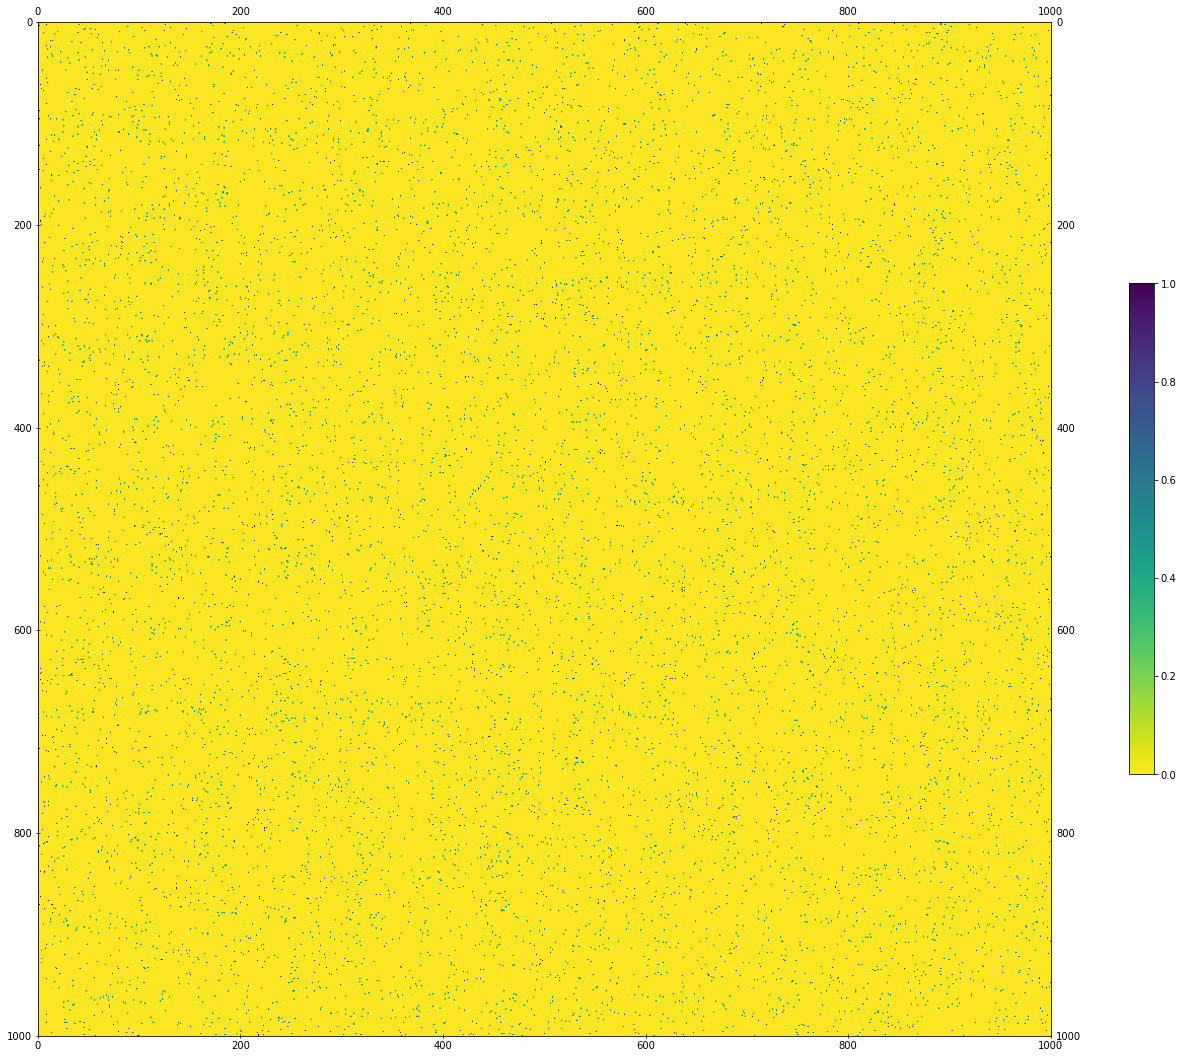

In [16]:
from seismiqb import plot_image
plot_image(bad_traces, figsize=(20, 20))